In [86]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import webrtcvad

%matplotlib inline


In [87]:
train_audio_path = "../train/audio/"
filename = "/yes/0a7c2a8d_nohash_0.wav"
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [88]:
def log_specgram(audio, sample_rate, window_size=20,
                step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                           fs=sample_rate,
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
#     print(nperseg, noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
    


(99, 161)


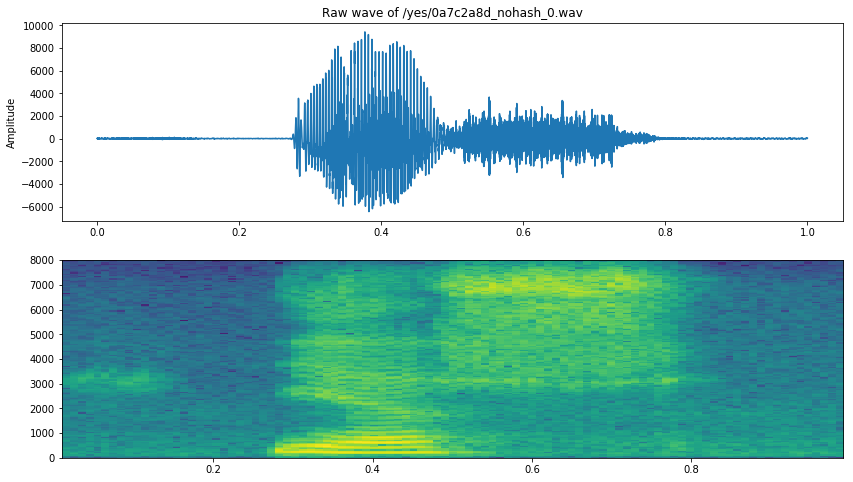

In [89]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title("Raw wave of " + filename)
ax1.set_ylabel("Amplitude")
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate)
         , samples)

ax2 = fig.add_subplot(212)
print(spectrogram.shape)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(),
                  freqs.max()])

In [93]:
human_labels = "yes no up down left right on off stop go silence unknown".split()
human_to_num = {human_label: i for i, human_label in enumerate(human_labels)}
num_to_human = {i: human_label for human_label, i in human_to_num.items()}

samples_path = "../train/validation_list.txt"
testing_path = "../train/testing_list.txt"

def gen_data_and_labels(samples_path):
    with open(samples_path) as file:
        tmp_data = []
        tmp_lb = []
        for line in file:
            au_file_path = line.strip()
            label, _ = os.path.split(au_file_path)
            sample_rate, samples = wavfile.read(str(train_audio_path) + au_file_path)
            if len(samples) != 16000:
    #             print(len(samples), label)
                continue
            _, _, specgram = log_specgram(samples, sample_rate)
            tmp_data.append(specgram.T)
            if label not in human_to_num:
                one_hot = np.zeros(len(human_labels))
                one_hot[human_to_num["unknown"]] = 1
                tmp_lb.append(one_hot)
            else:
                one_hot = np.zeros(len(human_labels))
                one_hot[human_to_num[label]] = 1
                tmp_lb.append(one_hot)
        data = np.array(tmp_data)
        labels = np.array(tmp_lb)
#         data = data.reshape(data.shape + (1,))
        return data, labels
    #     print(data.shape)

X, Y = gen_data_and_labels(samples_path)
x_test, y_test = gen_data_and_labels(testing_path)


In [94]:
X, Y = shuffle(X, Y)
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.10)
print(x_train.shape, y_train.shape)

(5523, 161, 99) (5523, 12)


In [96]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(99, input_shape=(161,99), return_sequences=True))
model.add(keras.layers.LSTM(99, input_shape=(161,99), return_sequences=True))
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(100, input_shape=(161,1), activation='relu'))
model.add(keras.layers.Dense(99, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(12, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid), batch_size=64)
model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 161, 99)           78804     
_________________________________________________________________
lstm_51 (LSTM)               (None, 161, 99)           78804     
_________________________________________________________________
flatten_10 (Flatten)         (None, 15939)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 99)                1578060   
_________________________________________________________________
dense_46 (Dense)             (None, 50)                5000      
_________________________________________________________________
dense_47 (Dense)             (None, 12)                612       
Total params: 1,741,280
Trainable params: 1,741,280
Non-trainable params: 0
_________________________________________________________________


[1.0169759407541454, 0.6787032579422916]